#  Final Assignment: Advanced Algorithms Design (session: July 8) 🏆 Final Assignment for Classiq Certificate 2 🏆

<div style="text-align: right">  by Daniela R. Trujillo </div>

**Assignment:**
Follow the example from Bootcamp 4Links to an external site. for creating the quantum walk operator for the case of a circle with 4 nodes, and design the quantum walk operator for the case of a line with 16 nodes:
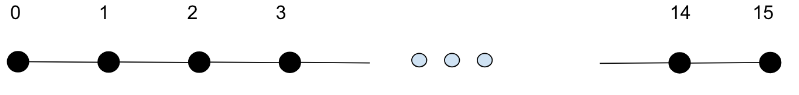

## Code and explanation

As a first step and top know with how many quntum channels we'll be working with we need to calculate them by applying the following formula: $$\text{log}_2(|V|),$$
where V is the set of vertices and $|V|$ is the number of vertices within the set. Since in this case $|V| = 16$, we'll be using 4 qubits for each vertix and another auxiliary 4 whose task will be to allocate the adjacents vertices

In [ ]:
from classiq import *
import numpy as np
size = 4

Now, we'll begin by building de C-operartor. We know that the C-operator is very similar to the diffuser operator, so we can create an oracle that can be implemented. For this, we will also use an auxiliary qubit prepared in the minus state. This auxiliary qubit is used to perform the phase kickback.

In [ ]:
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)


@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)


@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)



Now we perform the function that constructs the state we are in from the superposition of its neighbors, giving each a 50-50 chance. For this, it is important to highlight three cases:

1. If we are at the beginning, as it will have only one neighbor and this will carry all the probability.
2. The last number of the vertices will have a similar situation.
3. The final case includes all the middle numbers, each having two neighbors.

Then, we need to apply a CONTROL gate, which functions as an "if", depending on which vertex you find yourself in, the corresponding operators would apply. We need to apply the within_apply function, where what we sandwich will be the state we prepared from the adjacent states, with the diffuser operator in the middle. We need to apply this operator to all the vertices.

In [ ]:

def C_iteration(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = np.zeros(16)

    if i == 0:
        prob[i+1] = 1
    elif i == 2**size-1:
        prob[i-1] = 1
    else:
        prob[i+1] = 0.5
        prob[i-1] = 0.5
    
    print(f'State={i}, prob vec ={prob}')
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

@qfunc 
def C_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      C_iteration(i,vertices,adjacent_vertices)



Now we build the _S_ opeprator, which implements a swap among the vertices once the coin has been flipped.

First, we check which veritces are neighboors, for this we only need to do the sumbstraction among one and the others and only those whose differences is equal to $|1|$ will be neighboors.

In [ ]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= ((vertices-adjacent_vertices == 1) | (vertices-adjacent_vertices == -1))

    
@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count = x.len,
    iteration = lambda i: SWAP(x[i],y[i]))
  

Now, we check whether a vertix is neighbour with another, and if so it swaps them.

In [ ]:
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand = lambda: bitwise_swap(vertices,adjacent_vertices))



Finally, to complete the algorithm and implement the quantum walk, we initialize the qubits for the vertices and their adjacent vertices. We use a Hadamard gate to create a superposition of all the vertices, and then apply the constructed operators: _C_ and _S_ for the quantum walk.

In [ ]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):

  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  C_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

qmod = create_model(main)
qprog = synthesize(qmod)